## Updates
- Pytesseract attempt (done 23/6/2023)
- [Perspective Transformation (perspective)](https://towardsdatascience.com/perspective-versus-affine-transformation-25033cef5766) (done 27/6/2023)
- update codebase for ocrimg and dashboard
- further generalize and automate the image preprocessing

In [12]:
import cv2
import pytesseract
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np
import imutils
from sklearn.metrics import euclidean_distances
from resize_cv2 import resize_with_pad

In [13]:
#helper code
def gammaCorrection(src, gamma):
    invGamma = 1 / gamma

    table = [((i / 255) ** invGamma) * 255 for i in range(256)]
    table = np.array(table, np.uint8)

    return cv2.LUT(src, table)

In [192]:
def get_edges(img):
    '''input an image opened by invoking cv2.imread.
        output the same image reduced to its edges.'''
    ratio = img.shape[0] / img.shape[1]
    orig = img.copy()
    image = imutils.resize(img, height = 500)
    
    #top = int(0.05 * image.shape[0]) # shape[0] = rows
    top = int(0.1 * 1098) # shape[0] = rows
    bottom = top
    #left = int(0.05 * image.shape[1]) # shape[1] = cols
    left = int(0.1 * 648) # shape[1] = cols
    right = left
    
    #image = resize_with_pad(img, (1100, 648), (0, 0, 0))
    image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=(0, 0, 0))
    cv2.imshow("image with padding", image)
    cv2.waitKey(0)
    
    # convert the image to grayscale, blur it, and find edges
    # in the image
    gray = cv2.cvtColor(gammaCorrection(image, 1.05), cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    edged = cv2.Canny(gray, 70, 150)
    
    # show the original image and the edge detected image
    plt.imshow(edged)
    
    return edged

In [193]:
def get_all_boxes(edged):
	cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
	cnts = imutils.grab_contours(cnts)
	cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:5]
 
	# loop over the contours
	for c in cnts:
		# approximate the contour
		peri = cv2.arcLength(c, True)
		approx = cv2.approxPolyDP(c, 0.02 * peri, True)
		# if our approximated contour has four points, then we
		# can assume that we have found our screen
		if len(approx) >= 4:
			screenCnt = approx
			break

	return screenCnt

In [194]:
def select_coords(screenCnt):
    print("coordinate sets")
    print(screenCnt)
    screenCnt = screenCnt.reshape(len(screenCnt), 2)
    close_pairs = np.array(np.where(~((euclidean_distances(screenCnt, screenCnt) > 50) | (euclidean_distances(screenCnt, screenCnt) == 0)))).T

    pair_cleaned = []

    for p1, p2 in close_pairs:
        a = False
        for x1, x2 in pair_cleaned:
            if p1 == x2:
                a = not a
                break
        if not a:
            pair_cleaned.append((p1, p2))
            
    print(pair_cleaned)

    remove_points = np.array(pair_cleaned)[:, 1]

    mask = np.ones(len(screenCnt), dtype=bool) 
    mask[remove_points] = False
    result = screenCnt[mask]

    #sorted_points = np.array(sorted(result, key=lambda x: x[0]))
    left, right, top, bottom = min(result[:, 0]), max(result[:, 0]), min(result[:, 1]), max(result[:, 1])
    print(left, right, top, bottom)

    topleft = min(result, key=lambda x: euclidean_distances([x], [(left, top)]))
    topright = min(result, key=lambda x: euclidean_distances([x], [(right, top)]))
    bottomleft = min(result, key=lambda x: euclidean_distances([x], [(left, bottom)]))
    bottomright = min(result, key=lambda x: euclidean_distances([x], [(right, bottom)]))
    
    return topleft, topright, bottomleft, bottomright

In [195]:
def select_coords(screenCnt):
    screenCnt = screenCnt.reshape(len(screenCnt), 2)
    close_pairs = np.array(np.where(~((euclidean_distances(screenCnt, screenCnt) > 10) | (euclidean_distances(screenCnt, screenCnt) == 0)))).T

    if len(close_pairs):
        pair_cleaned = []

        for p1, p2 in close_pairs:
            a = False
            for x1, x2 in pair_cleaned:
                if p1 == x2:
                    a = not a
                    break
            if not a:
                pair_cleaned.append((p1, p2))

        remove_points = np.array(pair_cleaned)[:, 1]

        mask = np.ones(len(screenCnt), dtype=bool) 
        mask[remove_points] = False
        screenCnt = screenCnt[mask]

    #sorted_points = np.array(sorted(screenCnt, key=lambda x: x[0]))
    left, right, top, bottom = min(screenCnt[:, 0]), max(screenCnt[:, 0]), min(screenCnt[:, 1]), max(screenCnt[:, 1])
    print(left, right, top, bottom)

    topleft = min(screenCnt, key=lambda x: euclidean_distances([x], [(left, top)]))
    topright = min(screenCnt, key=lambda x: euclidean_distances([x], [(right, top)]))
    bottomleft = min(screenCnt, key=lambda x: euclidean_distances([x], [(left, bottom)]))
    bottomright = min(screenCnt, key=lambda x: euclidean_distances([x], [(right, bottom)]))
    
    return topleft, topright, bottomleft, bottomright

In [196]:
def transform_image(img):
    '''the official driver code for the whole process.
    Accepts an image as input, for OCRImg class
    Outputs the image required for pyt.image_to_string() call to OCR Engine.
    Assume that the image has already be resized'''
    
    #create aspect ratio for ID cards. can be changed for other documents
    max_w, max_h = 1098, 648
    
    #read the image and get its edges
    #image = cv2.resize(img, (max_w, max_h), interpolation = cv2.INTER_AREA)
    edged = get_edges(img)    
    boxes = get_all_boxes(edged)
    topleft, topright, bottomleft, bottomright = select_coords(boxes) #something sus here
    #print(topleft, topright, bottomleft, bottomright)

    #initialize points: input convert to top-down output
    input_pts = np.float32([list(coord) for coord in [topleft, bottomleft, bottomright, topright]])
    output_pts = np.float32([[0, 0],
                            [0, max_h - 1],
                            [max_w - 1, max_h - 1],
                            [max_w - 1, 0]])
    
    #plt.imshow(cv2.drawContours(img, [np.array([topleft, topright, bottomright, bottomleft]).reshape((4, 1, 2))], -1, (255,0,0), 2))
    #cv2.imshow("edged", edged)
    #cv2.waitKey(0)
    
    # Compute the perspective transform mat
    transform_mat = cv2.getPerspectiveTransform(input_pts, output_pts)
    out = cv2.warpPerspective(img, transform_mat, (max_w, max_h), flags=cv2.INTER_LINEAR)
    
    return out

## Regex and stuff

In [197]:
import regex as re
import json

def extract_text(img_path, lang):
    return pytesseract.image_to_string(Image.open(img_path), lang = lang)

def extract_name(ocr_result):
    # Define pattern to extract company
    company_pattern = r'(?i)(?:^|\b)([A-Z][A-Za-z]+(?: [A-Z][A-Za-z]+)*)(?:\b|$)'

    # Extract company using regular expression pattern
    company_match = re.search(company_pattern, ocr_result)
    if company_match:
        return company_match.group(1)
    else:
        return None

def extract_email(ocr_result):
    # Extract email address using regular expression pattern
    email_pattern = r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b'
    email_match = re.search(email_pattern, ocr_result, re.I)
    if email_match:
        return email_match.group()
    else:
        return None

def extract_company(ocr_result):
    # TODO: Define pattern to extract company
    company_pattern = r'(?i)(?:^|\b)([A-Z][A-Za-z]+(?: [A-Z][A-Za-z]+)*)(?:\b|$)'

    # Extract company using regular expression pattern
    company_match = re.search(company_pattern, ocr_result)
    if company_match:
        return company_match.group(1)
    else:
        return None

def extract_contact(ocr_result):
    # Extract contact number using regular expression pattern
    contact_number_pattern = r'\b\d+\b'
    contact_number_matches = re.findall(contact_number_pattern, ocr_result)
    contact_number = ''.join(contact_number_matches)
    if contact_number:
        return contact_number
    else:
        return None

# function to produce the json
def extract_json(img_path, lang):
    res_dict = {}
    
    extracted_txt = extract_text(img_path, lang = lang)
    res_dict["name"], res_dict["email"], res_dict["contact"], res_dict["company"] = extract_name(extracted_txt), extract_email(extracted_txt), extract_contact(extracted_txt), extract_contact(extracted_txt)
    
    res_json = json.dumps(res_dict)
    return res_json


## Driver code

This is the test case

64 546 109 608


'{"name": "Alexis Beckman", "email": "info@culturefrozenyogurt.com", "contact": "6503240440650324044834094306100", "company": "6503240440650324044834094306100"}'

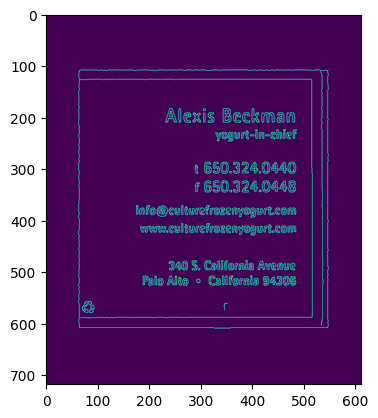

In [198]:
test_path = "./test/099.jpg_Reference.jpg"

img = cv2.imread(test_path)
test_img = imutils.resize(img, height = 500)
new_img = transform_image(test_img)

cv2.imshow("Test case", new_img)
cv2.waitKey(0)
cv2.destroyAllWindows()
pytesseract.image_to_string(new_img)

# testing the json function
extract_json(test_path, "eng")

In [108]:
cv2.imshow("normal", img)
cv2.waitKey(0)

-1